In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score, f1_score,roc_auc_score
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

In [71]:
df=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv')

In [72]:
df.shape

(32560, 15)

In [73]:
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB



### There are no missing values.

In [75]:
df.drop_duplicates(inplace=True)

In [76]:
df.shape

(32536, 15)


##  There were few duplicate observations which I successfully dropped.

In [77]:
df['Income'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [78]:
df.nunique()

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

In [79]:
df['Income'].value_counts()

 <=50K    24697
 >50K      7839
Name: Income, dtype: int64


## It is clear that this is a highly imbalanced dataset with the minority class occupying just 24% of the observations.

In [80]:
list_=[x for x in df.columns if df[x].nunique()>42]

In [81]:
len(list_)

5

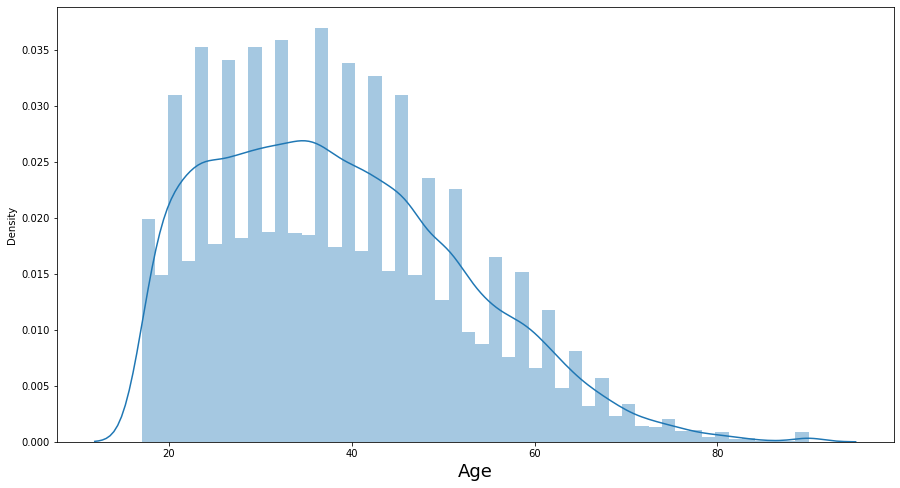

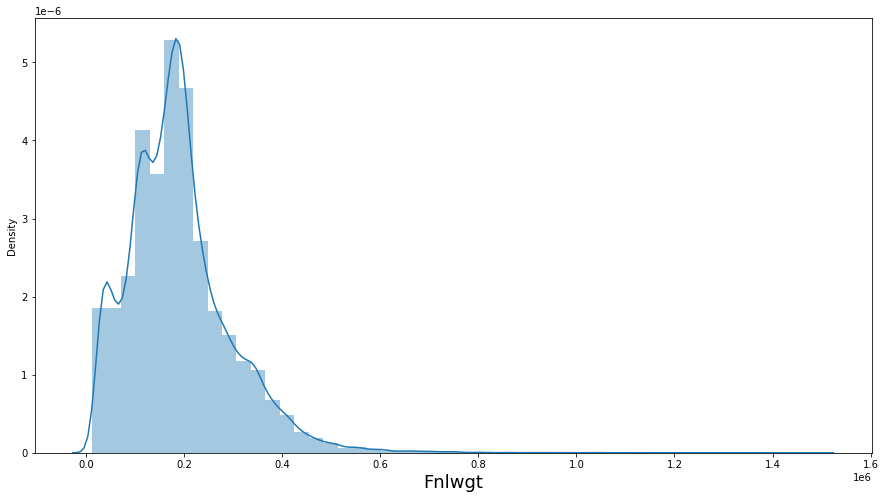

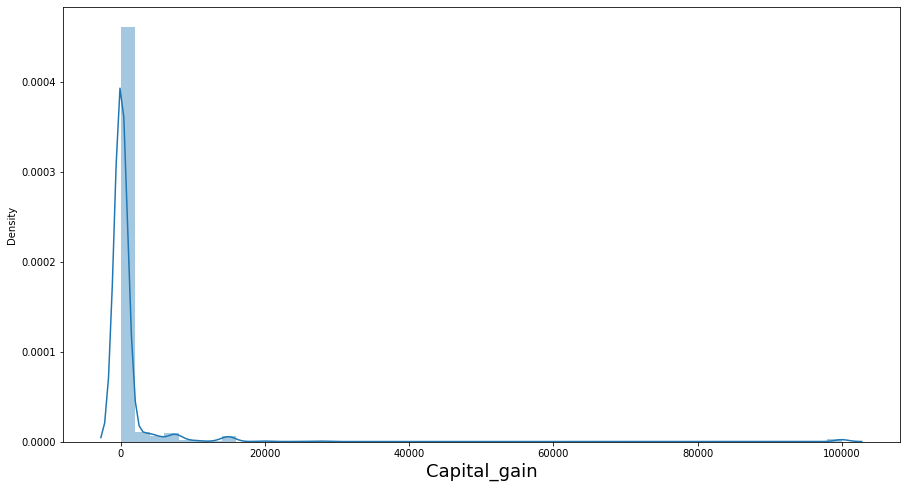

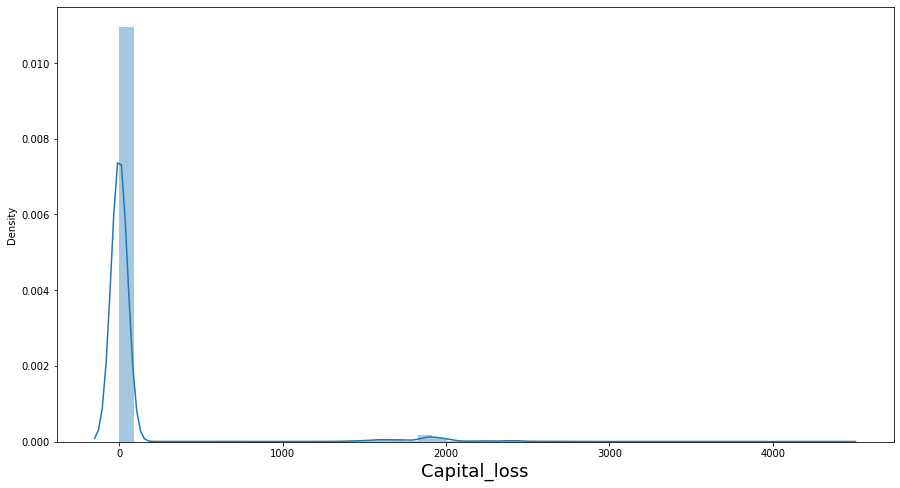

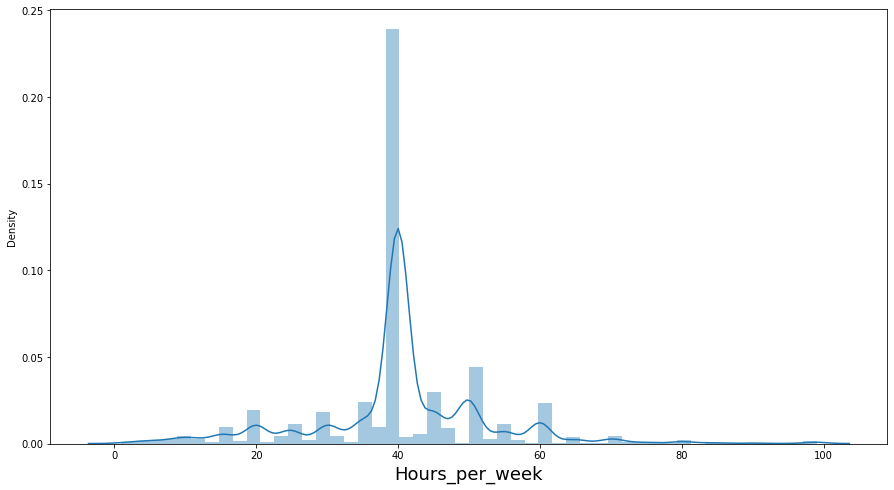

In [82]:
for i in list_:
  plt.figure(figsize=(15,8))
  sns.distplot(df[i])
  plt.xlabel(i,fontsize=18)
  plt.show()

### As the dataset is highly imbalanced, removing outliers might prove to be a way of loosing important information. Because the values that we cap might be corresponding to those minority classes.

In [84]:
df['Hours_per_week'].sort_values()

1261      1
22959     1
19749     1
8446      1
23535     1
         ..
5431     99
30991    99
21146    99
13579    99
12208    99
Name: Hours_per_week, Length: 32536, dtype: int64

In [83]:
df[list_].corr()

,Age,Fnlwgt,Capital_gain,Capital_loss,Hours_per_week
Age,1.000000,-0.076448,0.077676,0.057745,0.068515
Fnlwgt,-0.076448,1.000000,0.000433,-0.010267,-0.018900
Capital_gain,0.077676,0.000433,1.000000,-0.031638,0.078408
Capital_loss,0.057745,-0.010267,-0.031638,1.000000,0.054229
Hours_per_week,0.068515,-0.018900,0.078408,0.054229,1.000000


## Observations:
## 1.There is no multicollinearity within any features.

### Checking if the two classes are visually separable.


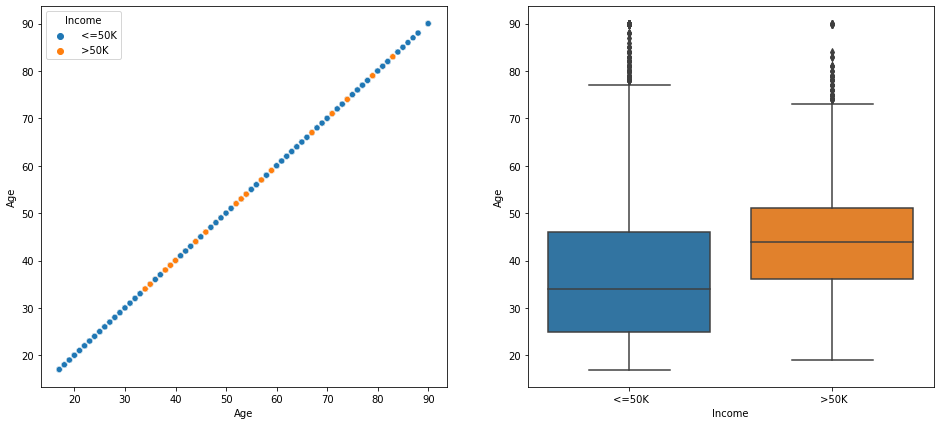

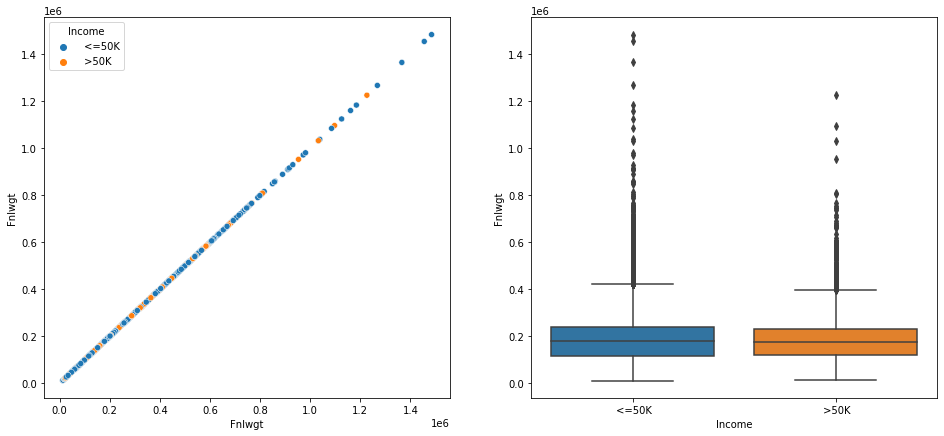

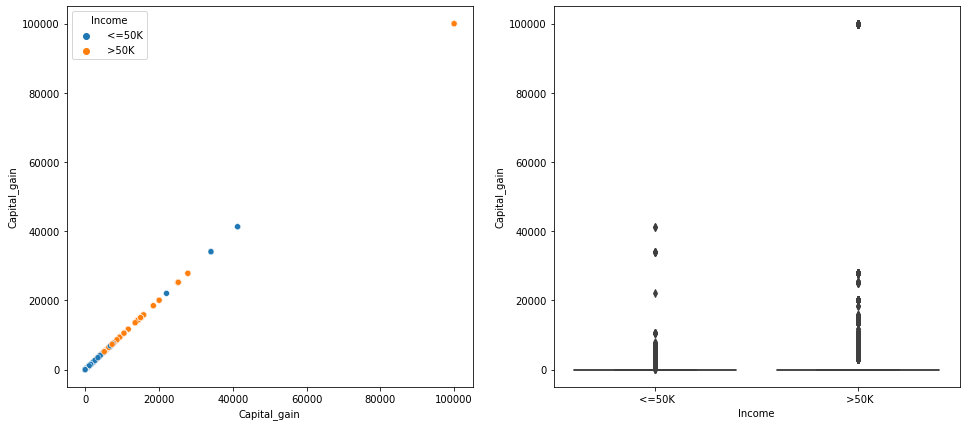

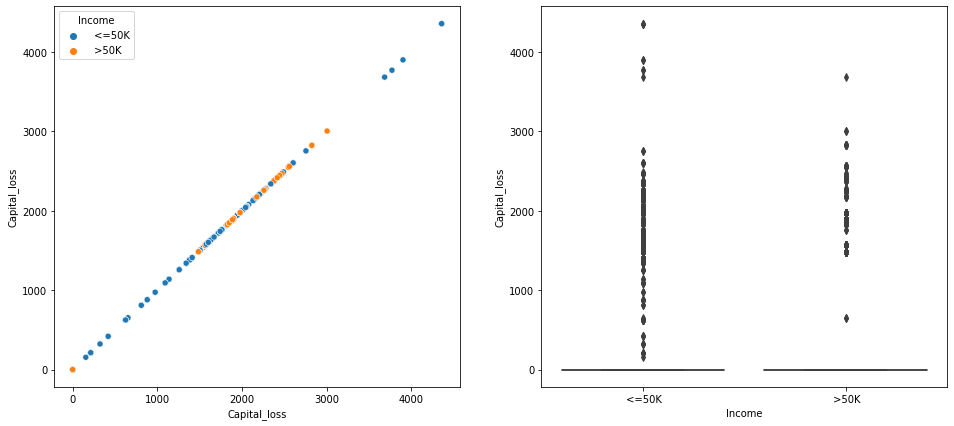

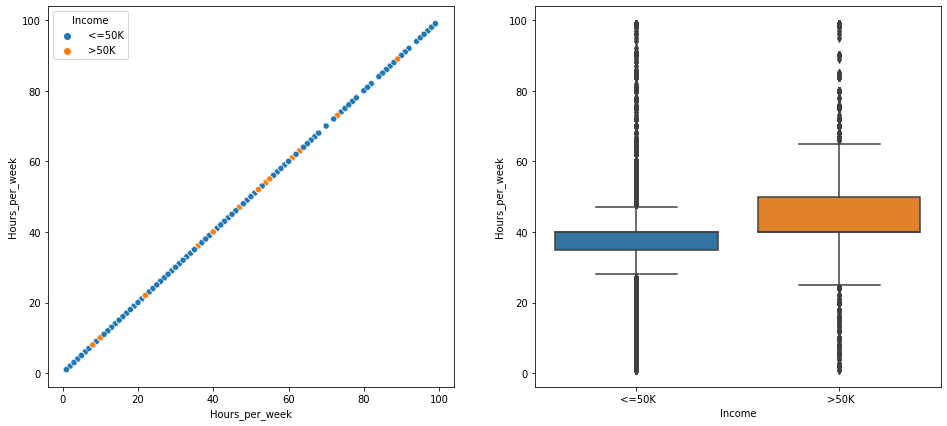

In [85]:
for i in list_:
  fig,axes=plt.subplots(1,2, figsize=(16,7))
  sns.scatterplot(df[i],df[i], hue=df['Income'],ax=axes[0])
  sns.boxplot(x=df['Income'],y=df[i],ax=axes[1])
  plt.show()


##  Columns like capital loss and capital gain show that the income is greater than 50k when the value of those features increase.
##  More the age, higher are the chances of the income being more than 50k.

In [25]:
categorical_cols=[x for x in df.columns if x not in list_]

In [26]:
df[categorical_cols].head()

,Workclass,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Native_country,Income
0,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
1,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
2,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
3,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K
4,Private,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,<=50K


In [27]:
for i in categorical_cols:
  print(df[i].value_counts())
  

 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
 HS-grad         10494
 Some-college     7282
 Bachelors        5352
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: Education, dtype: int64
9     10494
10     7282
13     5352
14     1722
11     1382
7      1175
12     1067
6       933
4       645
15      576
5       514
8       433
16      413
3       332
2       166
1        50
Name: Education_num, dtype: int64
 Married-civ-spouse       14970
 Never-married            10666
 Divorced                  4441
 Separa


##The 'Workclass', 'Native Counntry' and 'Occupation'
## column has a '?' value. I shall  replace it with another string.


In [86]:
df['Workclass']=df['Workclass'].apply(lambda x:'Other' if x in [' ?'] else x)
df['Native_country']=df['Native_country'].apply(lambda x:'Other' if x in [' ?'] else x)
df['Occupation']=df['Occupation'].apply(lambda x:'Other' if x in [' ?'] else x)

In [87]:
df['Education']=df['Education'].apply(lambda x:'School' if x in [' 11th',' 10th',' 7th-8th',' 9th',' 12th',' 5th-6th',' 1st-4th'] else x)

In [88]:
df['Education'].unique()

array([' Bachelors', ' HS-grad', 'School', ' Masters', ' Some-college',
       ' Assoc-acdm', ' Assoc-voc', ' Doctorate', ' Prof-school',
       ' Preschool'], dtype=object)

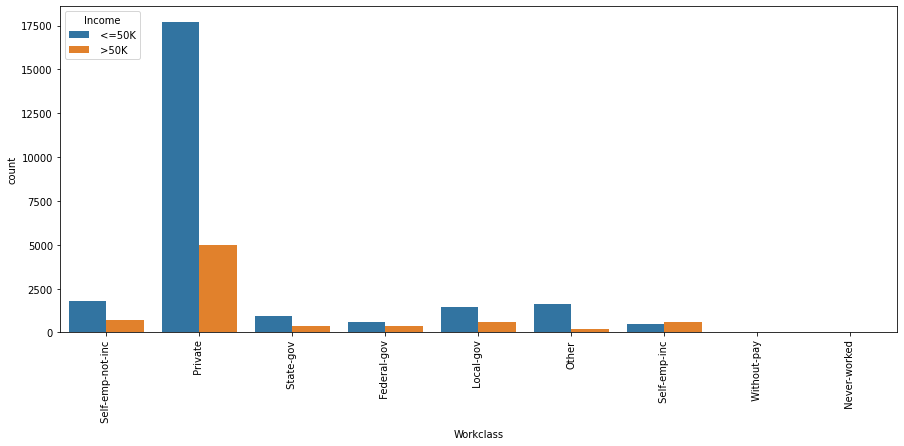

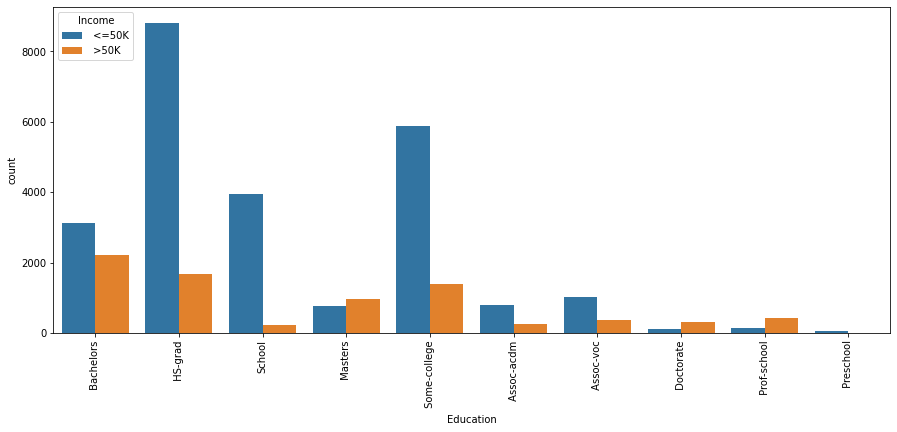

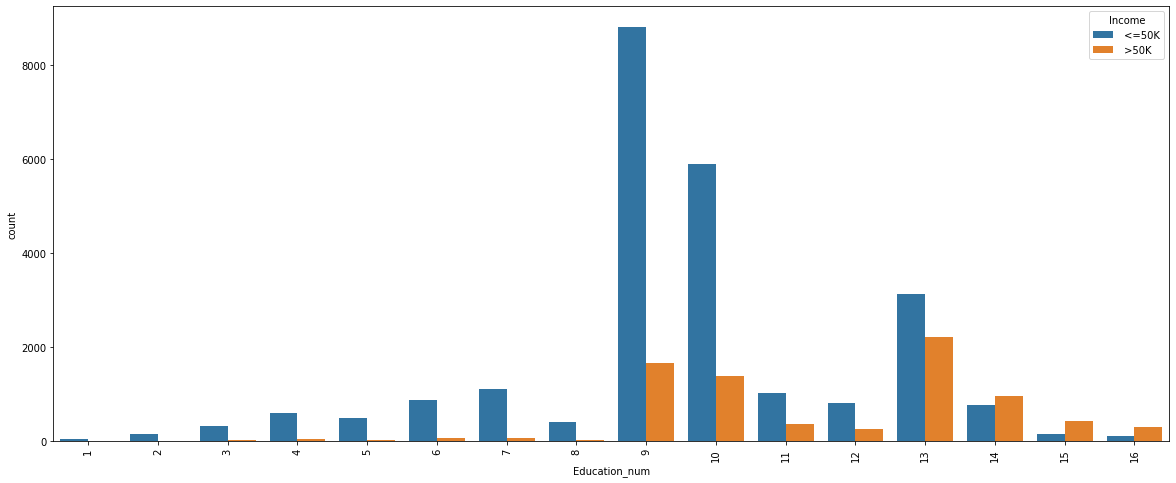

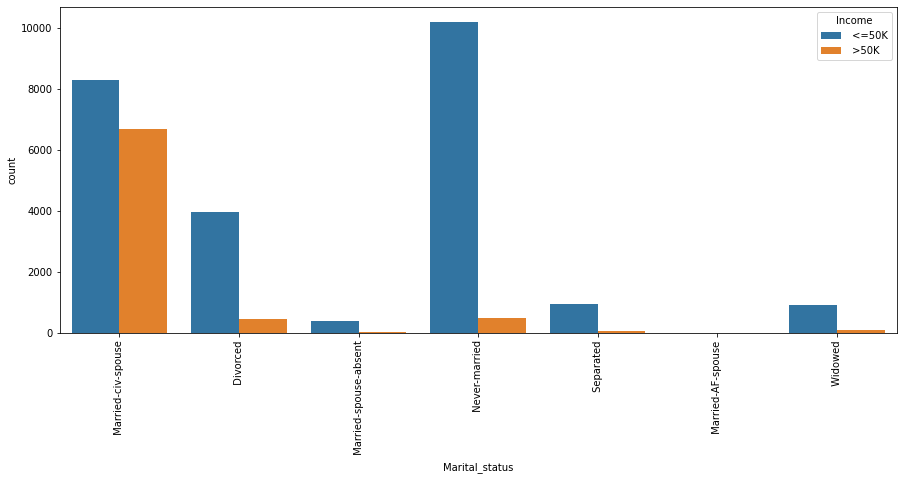

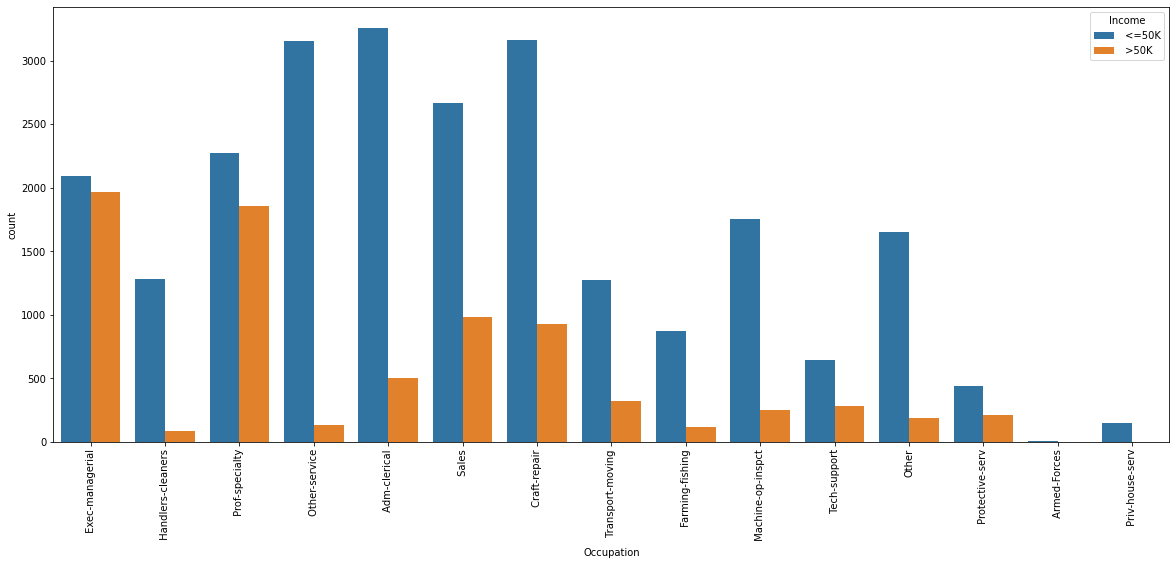

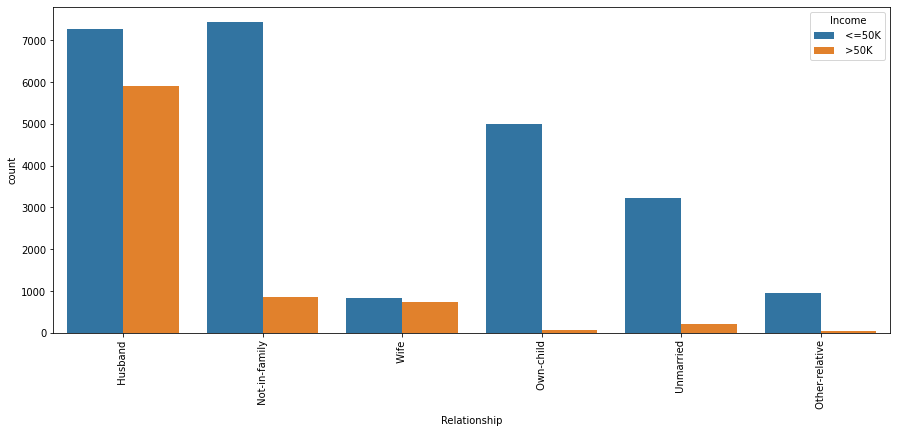

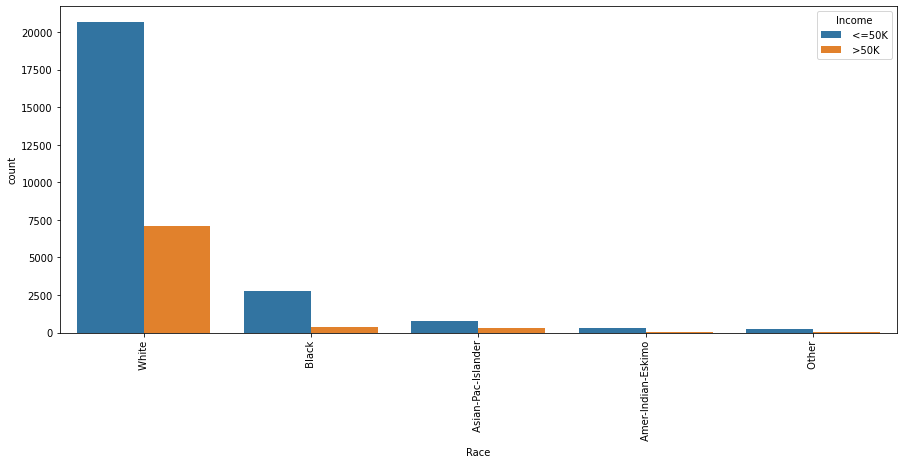

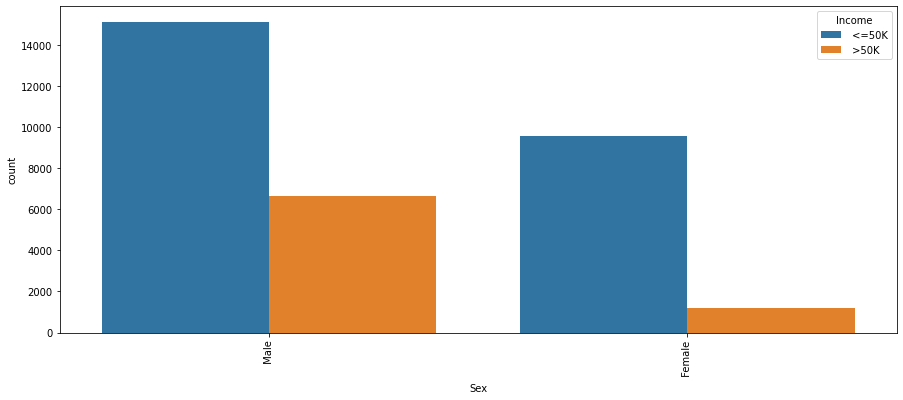

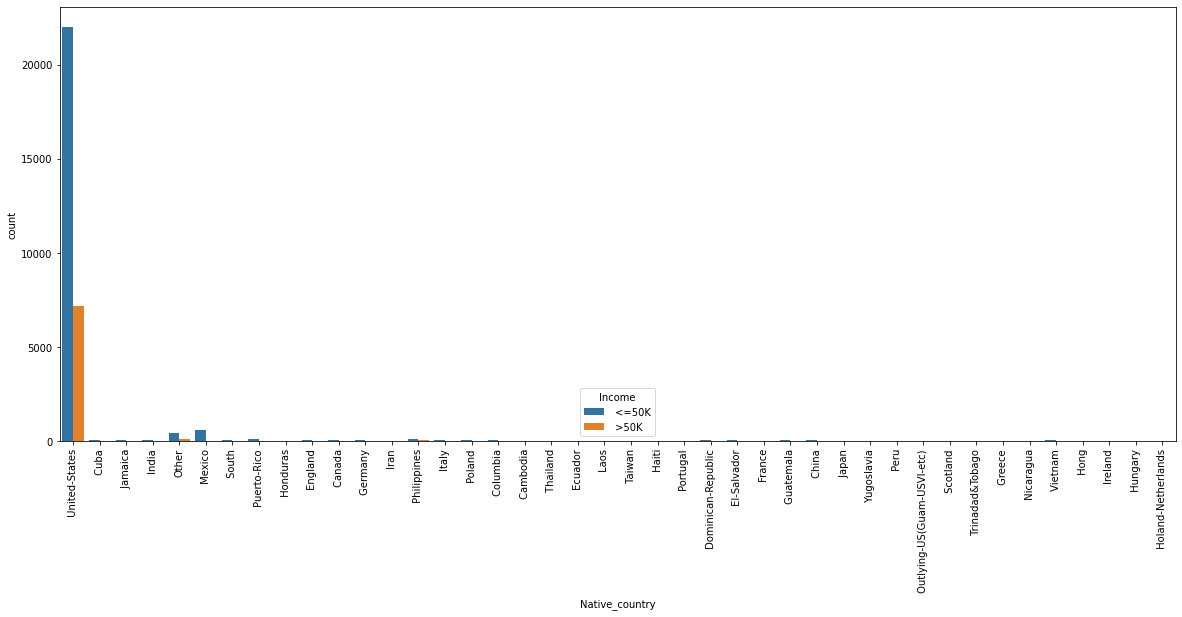

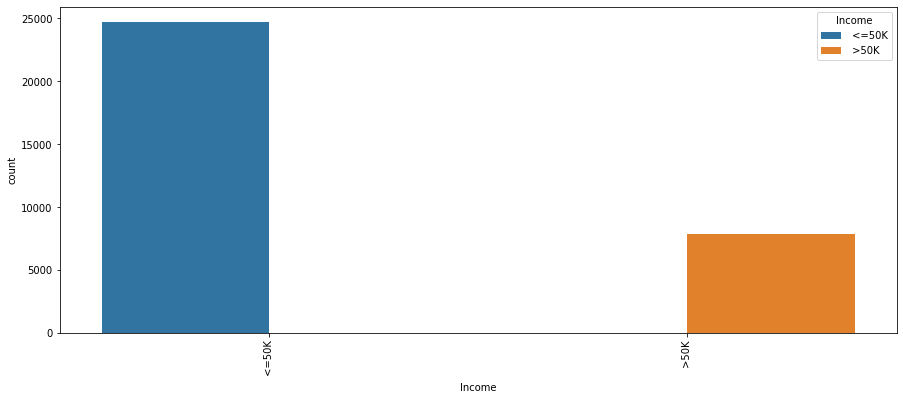

In [89]:
for i in categorical_cols:
  if df[i].nunique()>10:
    plt.figure(figsize=(20,8))
    sns.countplot(df[i],hue=df['Income'])
    plt.xticks(rotation=90)
    plt.show()
  else:
    plt.figure(figsize=(15,6))
    sns.countplot(df[i],hue=df['Income'])
    plt.xticks(rotation=90)
    plt.show()

In [90]:
df=pd.get_dummies(df,columns=['Workclass','Education','Marital_status','Occupation','Relationship','Race','Sex'],drop_first=True )

In [91]:
df.head()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Workclass_Other,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Education_School,Marital_status_ Married-AF-spouse,Marital_status_ Married-civ-spouse,Marital_status_ Married-spouse-absent,Marital_status_ Never-married,Marital_status_ Separated,Marital_status_ Widowed,Occupation_ Armed-Forces,Occupation_ Craft-repair,Occupation_ Exec-managerial,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Occupation_Other,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife,Race_ Asian-Pac-Islander,Race_ Black,Race_ Other,Race_ White,Sex_ Male
0,50,83311,13,0,0,13,United-States,<=50K,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,38,215646,9,0,0,40,United-States,<=50K,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2,53,234721,7,0,0,40,United-States,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,28,338409,13,0,0,40,Cuba,<=50K,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,37,284582,14,0,0,40,United-States,<=50K,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [92]:
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
encod = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
df['Native_country']= encod.fit_transform(df['Native_country'])
df['Income']= encod.fit_transform(df['Income'])


In [93]:
df.head()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,Workclass_ Self-emp-inc,Workclass_ Self-emp-not-inc,Workclass_ State-gov,Workclass_ Without-pay,Workclass_Other,Education_ Assoc-voc,Education_ Bachelors,Education_ Doctorate,Education_ HS-grad,Education_ Masters,Education_ Preschool,Education_ Prof-school,Education_ Some-college,Education_School,Marital_status_ Married-AF-spouse,Marital_status_ Married-civ-spouse,Marital_status_ Married-spouse-absent,Marital_status_ Never-married,Marital_status_ Separated,Marital_status_ Widowed,Occupation_ Armed-Forces,Occupation_ Craft-repair,Occupation_ Exec-managerial,Occupation_ Farming-fishing,Occupation_ Handlers-cleaners,Occupation_ Machine-op-inspct,Occupation_ Other-service,Occupation_ Priv-house-serv,Occupation_ Prof-specialty,Occupation_ Protective-serv,Occupation_ Sales,Occupation_ Tech-support,Occupation_ Transport-moving,Occupation_Other,Relationship_ Not-in-family,Relationship_ Other-relative,Relationship_ Own-child,Relationship_ Unmarried,Relationship_ Wife,Race_ Asian-Pac-Islander,Race_ Black,Race_ Other,Race_ White,Sex_ Male
0,50,83311,13,0,0,13,38,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,38,215646,9,0,0,40,38,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
2,53,234721,7,0,0,40,38,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,28,338409,13,0,0,40,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
4,37,284582,14,0,0,40,38,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


### **2. Using permutation Feature Importance**

In [94]:
X=df.drop(columns='Income')
y=df['Income']

In [95]:
X.shape

(32536, 54)

In [96]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y)

In [39]:
rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
from sklearn.inspection import permutation_importance

In [41]:
perm_impor = permutation_importance(rf, X_test, y_test)

In [42]:
perm_impor.importances_mean

array([ 1.59822965e-02, -1.62281780e-03,  6.88468158e-03,  3.69805754e-02,
        1.00319646e-02,  7.54856159e-03,  1.49987706e-03, -2.06540448e-03,
        0.00000000e+00, -1.35234817e-03, -4.42586673e-04,  6.14703713e-04,
        6.63880010e-04,  0.00000000e+00,  1.47528891e-04,  9.83525940e-05,
       -2.26210966e-03,  4.91762970e-05, -3.24563560e-03, -1.47528891e-03,
        0.00000000e+00,  4.17998525e-04, -3.19645931e-04,  5.90115564e-04,
       -1.22940743e-04,  2.39242685e-02, -2.45881485e-05,  2.38505041e-03,
       -7.37644455e-05,  9.83525940e-05,  0.00000000e+00,  4.91762970e-04,
        2.21293337e-03,  5.40939267e-04,  1.45070076e-03,  2.22044605e-17,
        6.88468158e-04, -2.45881485e-05, -8.60585198e-04,  7.62232604e-04,
       -1.25399557e-03, -1.47528891e-04,  5.90115564e-04, -1.72117040e-04,
        2.68010819e-03,  5.65527416e-04,  1.20481928e-03,  3.68822228e-04,
        1.13105483e-03, -4.42586673e-04, -3.44234079e-04,  7.37644455e-05,
       -2.45881485e-05,  

In [43]:
featimp_1=pd.DataFrame(zip(X.columns,perm_impor.importances_mean), columns=['columns','p_importance']).sort_values('p_importance',ascending=False)

In [44]:
featimp_1.reset_index(drop=True,inplace=True)

In [45]:
featimp_1['p_importance']

0     3.698058e-02
1     2.392427e-02
2     1.598230e-02
3     1.003196e-02
4     7.548562e-03
5     6.884682e-03
6     2.680108e-03
7     2.385050e-03
8     2.212933e-03
9     1.499877e-03
10    1.450701e-03
11    1.253996e-03
12    1.204819e-03
13    1.131055e-03
14    7.622326e-04
15    6.884682e-04
16    6.638800e-04
17    6.147037e-04
18    5.901156e-04
19    5.901156e-04
20    5.655274e-04
21    5.409393e-04
22    4.917630e-04
23    4.179985e-04
24    3.688222e-04
25    1.475289e-04
26    9.835259e-05
27    9.835259e-05
28    7.376445e-05
29    4.917630e-05
30    2.220446e-17
31    0.000000e+00
32    0.000000e+00
33    0.000000e+00
34    0.000000e+00
35   -2.458815e-05
36   -2.458815e-05
37   -2.458815e-05
38   -7.376445e-05
39   -1.229407e-04
40   -1.475289e-04
41   -1.721170e-04
42   -3.196459e-04
43   -3.442341e-04
44   -4.425867e-04
45   -4.425867e-04
46   -8.605852e-04
47   -1.253996e-03
48   -1.352348e-03
49   -1.475289e-03
50   -1.622818e-03
51   -2.065404e-03
52   -2.2621

In [46]:
imp_cols=featimp_1['columns'][0:19]

In [47]:
Xnew=X[imp_cols]
y=df['Income']

# **Support Vector Machine**

In [48]:
X_train,X_test,y_train,y_test=train_test_split(Xnew,y,test_size=0.30,stratify=y)

In [43]:
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [44]:
sv=svm.SVC(class_weight='balanced')
sv.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
y_trainpred=sv.predict(X_train)
y_testpred=sv.predict(X_test)

In [46]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84     17288
           1       0.54      0.87      0.66      5487

    accuracy                           0.79     22775
   macro avg       0.74      0.81      0.75     22775
weighted avg       0.85      0.79      0.80     22775



In [47]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      7409
           1       0.52      0.85      0.65      2352

    accuracy                           0.78      9761
   macro avg       0.73      0.80      0.74      9761
weighted avg       0.84      0.78      0.79      9761



# **Support Vector Machine with GridSearch CV**


In [48]:
sv_1=svm.SVC()
param={'kernel':['rbf','linear','poly'],'C':[0.1,0.0001,0.00001,0.00000001,1],'gamma':[0.001,0.0001,1,2,5], 'class_weight':['balanced','0:1,1:2']}
cv = StratifiedKFold(n_splits=3)
sv_grid=GridSearchCV(sv_1,param_grid=param,cv=cv, scoring='f1')
sv_grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.0001, 1e-05, 1e-08, 1],
                         'class_weight': ['balanced', '0:1,1:2'],
                         'gamma': [0.001, 0.0001, 1, 2, 5],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [49]:
y_trainpred=sv_grid.predict(X_train)
y_testpred=sv_grid.predict(X_test)

In [50]:
sv_grid.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'gamma': 5, 'kernel': 'poly'}

In [51]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       0.95      0.78      0.86     17288
           1       0.56      0.88      0.68      5487

    accuracy                           0.80     22775
   macro avg       0.76      0.83      0.77     22775
weighted avg       0.86      0.80      0.82     22775



In [52]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      7409
           1       0.54      0.86      0.67      2352

    accuracy                           0.79      9761
   macro avg       0.74      0.82      0.76      9761
weighted avg       0.85      0.79      0.80      9761



# **Decision Tree**

In [53]:
X_train,X_test,y_train,y_test=train_test_split(Xnew,y,test_size=0.30,stratify=y,random_state=465)

In [54]:
dtc=DecisionTreeClassifier(max_depth=10,max_features=19,class_weight={0:1,1:2},min_samples_leaf=8,min_samples_split=5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=10, max_features=19,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=8,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [55]:
y_trainpred=dtc.predict(X_train)
y_testpred=dtc.predict(X_test)

In [56]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     17288
           1       0.62      0.82      0.71      5487

    accuracy                           0.84     22775
   macro avg       0.78      0.83      0.80     22775
weighted avg       0.86      0.84      0.84     22775



In [57]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      7409
           1       0.62      0.82      0.71      2352

    accuracy                           0.83      9761
   macro avg       0.78      0.83      0.80      9761
weighted avg       0.86      0.83      0.84      9761



# **Grid Search CV on Decision Trees**

In [106]:
dtc1=DecisionTreeClassifier()
cv = StratifiedKFold(n_splits=3)
param={'class_weight':[{0:1,1:2},'balanced'],'max_depth':[20,15,16,21,14,13,12],'min_samples_leaf':[11,12,13,14,10],'max_features':[12,16,17,15],'ccp_alpha':[0.0001,0.00001,0.01,0.1,1]}
dt_s_grid=GridSearchCV(dtc1,param_grid=param,cv=cv,scoring='f1')
dt_s_grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
     

In [107]:
y_trainpred=dt_s_grid.predict(X_train)
y_testpred=dt_s_grid.predict(X_test)

In [108]:
dt_s_grid.best_params_

{'ccp_alpha': 0.0001,
 'class_weight': {0: 1, 1: 2},
 'max_depth': 21,
 'max_features': 16,
 'min_samples_leaf': 10}

In [109]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     17288
           1       0.67      0.79      0.73      5487

    accuracy                           0.86     22775
   macro avg       0.80      0.83      0.81     22775
weighted avg       0.87      0.86      0.86     22775



In [110]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      7409
           1       0.65      0.77      0.71      2352

    accuracy                           0.85      9761
   macro avg       0.79      0.82      0.80      9761
weighted avg       0.86      0.85      0.85      9761



# **Logistic Regression**

In [63]:
f1=0
for i in range(0,1000): 
  X_train,X_test,y_train,y_test=train_test_split(Xnew,y,test_size=0.30,stratify=y,random_state=i)
  scaler=StandardScaler()
  scaler.fit(X_train)
  xtrain=scaler.transform(X_train)
  xtest=scaler.transform(X_test)
  lr=LogisticRegression(class_weight='balanced')
  lr.fit(X_train,y_train)
  y_trainpred=lr.predict(xtrain)
  y_testpred=lr.predict(xtest)
  score=f1_score(y_test,y_testpred)
  if f1<score:
    f1=score
    random=i

In [64]:
X_train,X_test,y_train,y_test=train_test_split(Xnew,y,test_size=0.30,stratify=y,random_state=465)
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)
y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)

In [65]:
print(random, f1)

231 0.6089385474860335


In [66]:
f1_score(y_test,y_test_pred)

0.6768655447900731

In [67]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     17288
           1       0.57      0.84      0.68      5487

    accuracy                           0.81     22775
   macro avg       0.75      0.82      0.77     22775
weighted avg       0.85      0.81      0.82     22775



In [68]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      7409
           1       0.56      0.85      0.68      2352

    accuracy                           0.81      9761
   macro avg       0.75      0.82      0.77      9761
weighted avg       0.85      0.81      0.82      9761



# **Neural Networks**

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.metrics import Recall, FalsePositives, AUC, Precision

# defining a function to build the model
def creating_model():
    # creating the model
    model = Sequential()
    model.add(Dense(32, input_dim=19, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='sigmoid'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(2, activation='sigmoid'))
    
    # compile model
    adam = Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['Recall'])
    return model

model = creating_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 1,322
Trainable params: 1,322
Non-trainable params: 0
_________________________________________________________________
None


In [70]:
X_train.shape,y_train.shape

((22775, 19), (22775,))

In [71]:
from keras.utils.np_utils import to_categorical

y_traincat = to_categorical(y_train)
y_testcat = to_categorical(y_test)

In [72]:
model.fit(X_train,y_traincat, epochs=200,batch_size=20, verbose = 1)

Epoch 1/200
1139/1139 [==============================] - 2s 964us/step - loss: 0.5337 - recall: 0.7143
Epoch 2/200
1139/1139 [==============================] - 1s 944us/step - loss: 0.3779 - recall: 0.8201
Epoch 3/200
1139/1139 [==============================] - 1s 926us/step - loss: 0.3458 - recall: 0.8389
Epoch 4/200
1139/1139 [==============================] - 1s 939us/step - loss: 0.3405 - recall: 0.8413
Epoch 5/200
1139/1139 [==============================] - 1s 923us/step - loss: 0.3372 - recall: 0.8449
Epoch 6/200
1139/1139 [==============================] - 1s 924us/step - loss: 0.3353 - recall: 0.8455
Epoch 7/200
1139/1139 [==============================] - 1s 907us/step - loss: 0.3342 - recall: 0.8464
Epoch 8/200
1139/1139 [==============================] - 1s 942us/step - loss: 0.3333 - recall: 0.8464
Epoch 9/200
1139/1139 [==============================] - 1s 946us/step - loss: 0.3325 - recall: 0.8490
Epoch 10/200
1139/1139 [==============================] - 1s 928us/step -

In [73]:
y_trainpred=model.predict(X_train)
y_testpred=model.predict(X_test)

In [74]:
categoricalpred = np.argmax(y_trainpred,axis=1)
categoricalpred_test = np.argmax(y_testpred,axis=1)

print('Results for Categorical Model')
print(classification_report(y_train, categoricalpred))

Results for Categorical Model
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     17288
           1       0.71      0.65      0.68      5487

    accuracy                           0.85     22775
   macro avg       0.80      0.78      0.79     22775
weighted avg       0.85      0.85      0.85     22775



In [75]:
print(classification_report(y_test, categoricalpred_test))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7409
           1       0.69      0.66      0.67      2352

    accuracy                           0.85      9761
   macro avg       0.79      0.78      0.79      9761
weighted avg       0.84      0.85      0.85      9761



# **XGBoost**

In [ ]:
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(Xnew,y,test_size=0.30,stratify=y)

In [ ]:
param_grid={}

In [ ]:
xgb1=XGBClassifier()
# define grid search
grid = GridSearchCV(estimator=xgb1, param_grid=param_grid, cv=3, scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [ ]:
grid.best_params_

{}

In [ ]:
y_train_pred=grid.predict(X_train)
y_test_pred=grid.predict(X_test)

In [ ]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       863
           1       0.96      0.46      0.62       166

    accuracy                           0.91      1029
   macro avg       0.93      0.73      0.78      1029
weighted avg       0.91      0.91      0.90      1029



In [ ]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92       370
           1       0.59      0.18      0.28        71

    accuracy                           0.85       441
   macro avg       0.73      0.58      0.60       441
weighted avg       0.82      0.85      0.81       441



# **Linear Discriminant Analysis**

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [63]:
sc = StandardScaler()
X1 = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=0.25,stratify=y)

In [64]:
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train, y_train)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='lsqr', store_covariance=False, tol=0.0001)

In [65]:
y_trainpred=lda.predict(X_train)
y_testpred=lda.predict(X_test)

In [66]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18523
           1       0.71      0.55      0.62      5879

    accuracy                           0.84     24402
   macro avg       0.79      0.74      0.76     24402
weighted avg       0.83      0.84      0.83     24402



In [67]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6174
           1       0.71      0.57      0.63      1960

    accuracy                           0.84      8134
   macro avg       0.79      0.75      0.77      8134
weighted avg       0.83      0.84      0.83      8134



# **Linear Discriminant Analysis With GridSearch CV**

In [50]:
from sklearn.metrics import fbeta_score, make_scorer
z = make_scorer(fbeta_score, beta=2)


In [51]:
# sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(Xnew, y, test_size=0.25,stratify=y)
# X_train=sc.fit_transform(X_train)
# X_test=sc.transform(X_test)

In [56]:
lda1=LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=3,shuffle=True)
param={'solver':['svd','lsqr','eigen']}
ld_grid=GridSearchCV(lda1,param_grid=param,cv=cv,scoring=z)
ld_grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LinearDiscriminantAnalysis(n_components=None,
                                                  priors=None, shrinkage=None,
                                                  solver='svd',
                                                  store_covariance=False,
                                                  tol=0.0001),
             iid='deprecated', n_jobs=None,
             param_grid={'solver': ['svd', 'lsqr', 'eigen']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [57]:
y_trainpred=ld_grid.predict(X_train)
y_testpred=ld_grid.predict(X_test)

In [58]:
ld_grid.best_params_

{'solver': 'svd'}

In [59]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18523
           1       0.71      0.56      0.62      5879

    accuracy                           0.84     24402
   macro avg       0.79      0.74      0.76     24402
weighted avg       0.83      0.84      0.83     24402



In [60]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.90      6174
           1       0.72      0.54      0.62      1960

    accuracy                           0.84      8134
   macro avg       0.79      0.74      0.76      8134
weighted avg       0.83      0.84      0.83      8134



# **Resampling**

# **SMOTE Tomek Link with KNearest Neighbours**

In [76]:
from sklearn.neighbors import KNeighborsClassifier

In [77]:
knn=KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='distance',p=1)
knn.fit(X_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=1,
                     weights='distance')

In [78]:
y_trainpred=knn.predict(X_train)
y_testpred=knn.predict(X_test)

In [79]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     17288
           1       0.92      0.86      0.89      5487

    accuracy                           0.95     22775
   macro avg       0.94      0.92      0.93     22775
weighted avg       0.95      0.95      0.95     22775



In [80]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      7409
           1       0.64      0.57      0.60      2352

    accuracy                           0.82      9761
   macro avg       0.75      0.74      0.74      9761
weighted avg       0.81      0.82      0.82      9761



# **SMOTE Tomek Link with XGBoost**

In [ ]:
from imblearn.combine import SMOTETomek

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(Xnew.values,y,test_size=0.30,stratify=y)

In [ ]:
smt=SMOTETomek(random_state=139)
X_train, y_train=smt.fit_resample(X_train,y_train)

In [ ]:
X_train.shape

(1536, 19)

In [ ]:
X_test.shape

(441, 19)

In [ ]:
# define evaluation procedure
cv = StratifiedKFold(n_splits=3, shuffle=True)
xgb_1=XGBClassifier()
# define grid search
grid = GridSearchCV(estimator=xgb_1, param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None, param_grid={},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

In [ ]:
y_trainpred=grid.predict(X_train)
y_testpred=grid.predict(X_test)

In [ ]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91       768
           1       0.92      0.90      0.91       768

    accuracy                           0.91      1536
   macro avg       0.91      0.91      0.91      1536
weighted avg       0.91      0.91      0.91      1536



In [ ]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       370
           1       0.37      0.37      0.37        71

    accuracy                           0.80       441
   macro avg       0.62      0.62      0.62       441
weighted avg       0.80      0.80      0.80       441



# **Decision Tree with SMOTE Tomek Link**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(Xnew.values,y,test_size=0.30,stratify=y)

In [ ]:
smt=SMOTETomek(random_state=139,)
X_train, y_train=smt.fit_resample(X_train,y_train)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(Xnew,y,test_size=0.30,stratify=y,random_state=465)

In [ ]:
dt=DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_trainpred=dt.predict(X_train)
y_testpred=dt.predict(X_test)

In [ ]:
print(classification_report(y_train,y_trainpred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       863
           1       1.00      1.00      1.00       166

    accuracy                           1.00      1029
   macro avg       1.00      1.00      1.00      1029
weighted avg       1.00      1.00      1.00      1029



In [ ]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       370
           1       0.32      0.34      0.33        71

    accuracy                           0.78       441
   macro avg       0.60      0.60      0.60       441
weighted avg       0.78      0.78      0.78       441



# ***Saving the model which have given the best f1 score so far and the model is Decision tree the score is 71***

# **Model Saving**

In [ ]:
dtc=DecisionTreeClassifier(max_depth=10,max_features=19,class_weight={0:1,1:2},min_samples_leaf=8,min_samples_split=5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=10, max_features=19,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=8,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [ ]:
y_trainpred=dtc.predict(X_train)
y_testpred=dtc.predict(X_test)

In [ ]:
print(classification_report(y_test,y_testpred))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      7409
           1       0.62      0.82      0.71      2352

    accuracy                           0.83      9761
   macro avg       0.78      0.83      0.80      9761
weighted avg       0.86      0.83      0.84      9761



In [116]:
import pickle
 
# Save the trained model as a pickle string.
saved_model = pickle.dumps(dtc)
 
# Load the pickled model
dtc_from_pickle = pickle.loads(saved_model)
 
# Use the loaded pickled model to make predictions
dtc_from_pickle.predict(X_test)

array([0, 0, 0, ..., 0, 1, 1])